<a href="https://colab.research.google.com/github/LAICEROO/ML_LAB/blob/main/ML_LAB_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#import potrzebnych bibliotek
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets

In [47]:
#definicja funkcji aktywacji sigmoid(x) i jej pochodnej
def sigmoid(x):
  return 1/(1+np.exp(-x))
def sigmoid_der(x):
  return sigmoid(x)*(1-sigmoid(x))

In [48]:
#definicja klasy (wzoru/szablonu)
#dla warstwy neuronów z funkcja aktywacji sigmoid( wagi * wejscia + bias)
#do latwego obliczania opdowiedzi warstwy neuronow na dane wejsciowe
#oraz do aktualizacji wag tak aby zminimalizowac funkcje kosztu
class Sigmoid:
#tworzac obiekt reprezentujacy warstwe nalezy podac z ilu wejsc ma warstwa
#odczytywac wartosci (zwykle jest to liczba wyjsc poprzedniej warstwy)
#oraz liczbe neuronow w warstwie
  def __init__(self, number_of_input_nodes, number_of_neurons):
    self.weights = np.random.randn(number_of_input_nodes, number_of_neurons )
    self.biases = np.random.randn(1,number_of_neurons)

#obliczanie odpowiedzi warstwy na dane podane w input_data
  def forward_prop(self, input_data):
    self.orig_input = input_data
    self.input_data = input_data #to be used in backprop
    self.XW_B = np.dot(self.input_data, self.weights) + self.biases
    self.output_val = sigmoid(self.XW_B)
    return self.output_val

#zmiana wag i biasow dla neuronow warstwy w kierunku powodujacym zmniejszenie
#funkcji kosztu oraz obliczenie lancuszka pochodnych (gradientu) dla wczesniejszej warstwy
#ktory jest potrzebny do analogicznej poprawy wartosci wag i biasow
  def back_prop(self, gradient, learning_rate):

    #pochodna funkcji aktywacji
    layer_activation_der = sigmoid_der(self.XW_B)

    #do obliczenia dJ_dweight dla warstwy wczesniejszej
    #potrzebne sa aktualne wartosci wag aktualnej warstwy
    dXWB__dinputs = self.weights.copy()

    #obliczamy dJ_dwagi oraz DJ_dbiases dla aktualnej warstwy
    dJ_dweights = self.input_data.T @ (gradient * layer_activation_der)
    dJ_dbiases = np.sum((gradient * layer_activation_der),axis=0)

    #zmieniamy wagi i biasy w kierunku ktory powoduje zmniejszenie funkcji kosztu J
    #o czym mowi nam pochodna
    self.weights -= learning_rate * dJ_dweights
    self.biases -= learning_rate * dJ_dbiases

    #obliczamy gradient_do_zwrotu (lancuch pochodnych) potrzebny
    #do obliczenia dJ_dweights od dJ_biases przez wczesniejsza (po lewej) warstwe neuronow
    gradient_do_zwrotu = (gradient * layer_activation_der) @ dXWB__dinputs.T
    return gradient_do_zwrotu

In [49]:
#definicja ostatniej warstwy sieci neuronowej
#do rozpoznania klasy obrazka "wlozonego" na wejscie sieci neuronowej
#np pies lub kot
#Warstwa ma tyle neuronow co klas do rozponania
#Kazdy neuron zwraca prawdopodobienstwo ze obiekt na wejsciu nalezy
#do klasy reprezentowanej przez niego

class Softmax:
  def __init__(self, input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node)/input_node
    self.bias = np.zeros(softmax_node)

  def forward_prop(self, image):
    self.orig_im_shape = image.shape #used in backprop
    image_modified = image.flatten()
    self.modified_input = image_modified #to be used in backprop
    output_val = np.dot(image_modified, self.weight) + self.bias
    self.out = output_val
    exp_out = np.exp(output_val)
    return exp_out/np.sum(exp_out, axis=0)

  def back_prop(self, dL_dout, learning_rate):
    for i, grad in enumerate(dL_dout):
      if grad ==0:
        continue

      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      #gradients with respect to out (z)
      dy_dz = -transformation_eq[i]*transformation_eq / (S_total **2)
      dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total **2)

      #gradients of totals against weights/biases/input
      dz_dw = self.modified_input
      dz_db = 1
      dz_d_inp = self.weight

      #gradients of loss against totals
      dL_dz = grad * dy_dz

      #gradients of loss against weights/biases/input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz * dz_db
      dL_d_inp = dz_d_inp @ dL_dz

    self.weight -= learning_rate *dL_dw
    self.bias -= learning_rate * dL_db

    return dL_d_inp.reshape(self.orig_im_shape)

In [50]:
sigmoid_layer1 = Sigmoid(784,15)
sigmoid_layer2 = Sigmoid(15,15)
softmax = Softmax(15, 10)

In [51]:
#Pobieramy zbior MNIST korzystajac z biblioteki keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#bierzemy tylko 1500 pierwszych cyferek bo wolno sie liczy
train_images = X_train[:1500]
train_labels = y_train[:1500]
test_images = X_test[:1500]
test_labels = y_test[:1500]

In [52]:
#rozmiar tablicy przechowujacej cyferke
print(train_images.shape)
#rozmiar cyferki
print(train_images[0].shape)

(1500, 28, 28)
(28, 28)


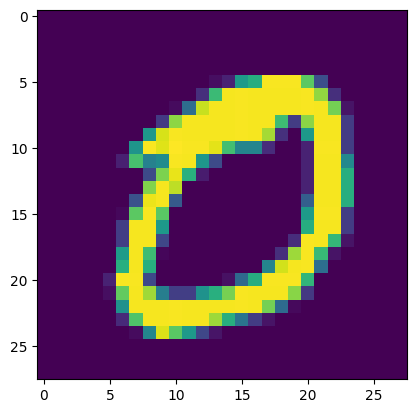

In [53]:
#wyswietlamy LOSOWA cyferke z 1500 pierwszych
from random import randint
numer_obrazka=randint(0,1499)
plt.imshow(train_images[numer_obrazka])

(784, 1)


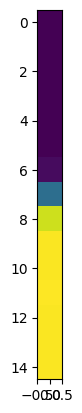

In [54]:
#splaszczenie obrazka
img = train_images[numer_obrazka]
img_flattened = np.reshape(img, (img.shape[0]*img.shape[1],1))
print(img_flattened.shape)
#fragment obrazka
plt.imshow(img_flattened[200:215,:])

In [55]:
#przelicz obrazek przez siec NN
def forward_prop(image, label):
  #splaszczenie
  #print("rozmiary obrazka oryginalne")
  #print(image.shape)
  image = np.reshape(image, (1, img.shape[0]*img.shape[1]))
  #print("rozmiary obrazka przed wrzuceniem do sieci")
  #print(image.shape)

  out_p = sigmoid_layer1.forward_prop((image /255) -0.5) #maly data engineering dla obrazka
  out_p = sigmoid_layer2.forward_prop(out_p)
  out_p = softmax.forward_prop(out_p)

  #calculate cross-entropy loss and accuracy
  cross_ent_loss = -np.log(out_p[label])

  #sprawdzenie czy rozpoznano prawidlowo obrazek 1/TAK 0/NIE
  accuracy_eval = 1 if np.argmax(out_p) == label else 0

  return out_p, cross_ent_loss, accuracy_eval

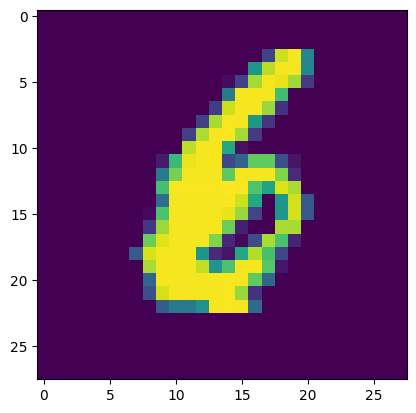

Wartosci na output neuronow warstwy softmax
[0.09594415 0.09344548 0.09008642 0.12823686 0.08385226 0.08597603
 0.12724179 0.10722676 0.07961683 0.10837342]
Wartosc funkcji kosztu
2.061666166900581
Czy poprawnie sklasyfikowano 0 - NIE, 1 - TAK
0


In [56]:
#test czy obrazek przejdzie przez siec
shuffle_data = np.random.permutation(len(train_images))
train_images = train_images[shuffle_data]
train_labels = train_labels[shuffle_data]
#jaka cyferka wrzucona na wejscie sieci
plt.imshow(train_images[0])
plt.show()
#zaobaczmy co zwraca siec na podany na jej wejsciu obrazek
wynik = forward_prop(train_images[0], train_labels[0])
print("Wartosci na output neuronow warstwy softmax")
print(wynik[0])
print("Wartosc funkcji kosztu")
print(wynik[1])
print("Czy poprawnie sklasyfikowano 0 - NIE, 1 - TAK")
print(wynik[2])

In [57]:
#uczenie sieci
def train_nn(image, label, learn_rate =0.005):
  #forward
  out, loss, acc = forward_prop(image, label)

  #calculate ininital gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  #brackprop
  grad_back = softmax.back_prop(gradient, learn_rate)
  grad_back = sigmoid_layer2.back_prop( grad_back, learn_rate)
  grad_back = sigmoid_layer1.back_prop( grad_back, learn_rate)

  return loss, acc

train_nn(train_images[0], train_labels[0])

(2.061666166900581, 0)

In [60]:
#training cnn
for epoch1 in range(14):
  print('Epoch %d ->'% (epoch1 +1))

  #shuffle the training data
  shuffle_data = np.random.permutation(len(train_images))
  train_images = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  #training the CNN
  loss = 0.0
  num_correct = 0

  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 0:
      print('%d steps out of 100 steps: Average Loss %.3f and Accuracy: %d%%' %(i+1, loss/100, num_correct))
      loss = 0
      num_correct = 0
    #wrzucamy obrazek do sieci i poprawiamy wagi sieci aby
    #siec w kolejnej epoce dla ten obrazek rozpoznala lepiej


    l1, accu = train_nn(im, label)
    loss += l1

    num_correct +=accu

Epoch 1 ->
1 steps out of 100 steps: Average Loss 0.000 and Accuracy: 0%
101 steps out of 100 steps: Average Loss 2.133 and Accuracy: 30%
201 steps out of 100 steps: Average Loss 2.106 and Accuracy: 35%
301 steps out of 100 steps: Average Loss 2.175 and Accuracy: 24%
401 steps out of 100 steps: Average Loss 2.044 and Accuracy: 35%
501 steps out of 100 steps: Average Loss 2.120 and Accuracy: 32%
601 steps out of 100 steps: Average Loss 2.104 and Accuracy: 31%
701 steps out of 100 steps: Average Loss 2.140 and Accuracy: 28%
801 steps out of 100 steps: Average Loss 2.142 and Accuracy: 24%
901 steps out of 100 steps: Average Loss 2.181 and Accuracy: 24%
1001 steps out of 100 steps: Average Loss 2.141 and Accuracy: 28%
1101 steps out of 100 steps: Average Loss 2.100 and Accuracy: 26%
1201 steps out of 100 steps: Average Loss 2.072 and Accuracy: 35%
1301 steps out of 100 steps: Average Loss 2.074 and Accuracy: 38%
1401 steps out of 100 steps: Average Loss 2.112 and Accuracy: 30%
Epoch 2 ->
1

In [61]:
#testing the accuracy of cnn

print('**testing phase')
loss = 0
num_correct = 0

for im, label in zip(test_images, test_labels):
  _, l1, accu = forward_prop(im, label)
  loss += l1
  num_correct += accu

num_test = len(test_images)
print('Test Loss:', loss /num_test)
print('Test accuracy:', num_correct / num_test)

**testing phase
Test Loss: 1.5648429453308836
Test accuracy: 0.4786666666666667
